# **1. 라이브러리 임포트 및 데이터 로드**


---



*   필요한 라이브러리를 임포트하고 아이리스 데이터셋을 로드합니다.
*   pandas와 numpy는 데이터 처리를, sklearn은 머신러닝 모델 구축을, matplotlib과 seaborn은 데이터 시각화를 위해 사용됩니다.



In [96]:
# 필요한 라이브러리 임포트
import pandas as pd  # 데이터 처리를 위한 pandas 라이브러리
import numpy as np  # 수치 연산을 위한 numpy 라이브러리
from sklearn.model_selection import train_test_split, GridSearchCV  # 데이터 분할 및 하이퍼파라미터 튜닝을 위한 도구
from sklearn.preprocessing import StandardScaler  # 특성 스케일링을 위한 도구
from sklearn.linear_model import SGDClassifier  # 확률적 경사 하강법 분류기
from sklearn.pipeline import Pipeline  # 데이터 처리 및 모델링 단계를 연결하는 파이프라인
import matplotlib.pyplot as plt  # 데이터 시각화를 위한 matplotlib
import seaborn as sns  # 고급 데이터 시각화를 위한 seaborn

# 데이터 로드
url = "https://raw.githubusercontent.com/jmnote/zdata/master/R/iris.csv"  # 아이리스 데이터셋 URL
iris = pd.read_csv(url)  # pandas를 사용하여 CSV 파일 읽기

# **2. 특성 공학**


---



*   특성 공학을 수행합니다. 기존 특성들을 조합하여 새로운 특성을 만들어냅니다.
*   모델이 데이터의 숨겨진 패턴을 더 잘 포착할 수 있도록 도와줍니다. 특성 간의 비율과 면적을 계산함으로써, 꽃의 형태에 대한 추가적인 정보를 제공합니다.
*   기본 데이터세트로 확률적 경사 하강법 진행 시에 양이 너무 적어 과대적합이 일어나 데이터의 양을 늘리기 위해 특성 공학을 진행했습니다.




In [97]:
# 특성 공학: 새로운 특성 생성
# 기존 특성을 조합하여 새로운 인사이트를 얻기 위한 특성 생성
iris['sepal_ratio'] = iris['Sepal.Length'] / iris['Sepal.Width']  # 꽃받침 길이/너비 비율
iris['petal_ratio'] = iris['Petal.Length'] / iris['Petal.Width']  # 꽃잎 길이/너비 비율
iris['sepal_area'] = iris['Sepal.Length'] * iris['Sepal.Width']  # 꽃받침 면적
iris['petal_area'] = iris['Petal.Length'] * iris['Petal.Width']  # 꽃잎 면적

# **3. 데이터 증강**



---


*   각 클래스에 대해 새로운 샘플을 생성하여 데이터셋의 크기를 늘립니다.
*   모델이 과대적합을 피하고 더 일반화된 학습을 할 수 있도록 돕기 위해 사용했습니다
*   추가적인 이유로는 클래스 불균형 해소, 견고성 향상, 모델 성능 향상을 위해 사용했습니다



In [98]:
# 데이터 증강: 각 클래스별로 약간의 노이즈를 추가하여 새로운 샘플 생성
def augment_data(X, y, n_samples=100):
    augmented_X = []
    augmented_y = []
    for class_label in np.unique(y):
        class_samples = X[y == class_label]
        mean = np.mean(class_samples, axis=0)  # 클래스별 평균 계산
        cov = np.cov(class_samples, rowvar=False)  # 클래스별 공분산 계산
        new_samples = np.random.multivariate_normal(mean, cov, n_samples)  # 새로운 샘플 생성
        augmented_X.append(new_samples)
        augmented_y.extend([class_label] * n_samples)
    return np.vstack(augmented_X), np.array(augmented_y)

# 특성 선택 및 레이블 분리
X = iris[['Sepal.Length', 'Sepal.Width', 'Petal.Length', 'Petal.Width',
          'sepal_ratio', 'petal_ratio', 'sepal_area', 'petal_area']].to_numpy()
y = iris['Species'].to_numpy()

# 데이터 증강 적용
X_aug, y_aug = augment_data(X, y, n_samples=100)  # 각 클래스당 100개의 새 샘플 생성
X = np.vstack([X, X_aug])  # 원본 데이터와 증강된 데이터 결합
y = np.concatenate([y, y_aug])  # 원본 레이블과 증강된 레이블 결합

# **4. 데이터 분할**

---
*   데이터를 훈련 세트와 테스트 세트로 분할
*   모델의 일반화 성능을 평가하기 위해 필수적인 요소
*   훈련 세트로 모델을 학습시키고, 테스트 세트로 모델의 성능을 평가





In [99]:
# 데이터 분할: 훈련 세트와 테스트 세트로 나누기
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2024)

# **5. 모델 파이프라인 구축**



---


*   데이터 전처리와 모델 학습을 연결하는 파이프라인을 구축
*   파이프라인을 구축함으로써 데이터 누수, 하이퍼파라미터 튜닝 용이성을 보장했습니다
*   StandardScaler는 특성들을 정규화하여 모든 특성이 동일한 스케일을 갖도록 하는 역할
*   SGDClassifier는 확률적 경사 하강법을 사용하는 분류기로 사용



In [100]:
# 파이프라인 생성: 데이터 전처리와 모델 학습을 연결
pipeline = Pipeline([
    ('scaler', StandardScaler()),  # 특성 스케일링
    ('classifier', SGDClassifier(random_state=2024))  # SGD 분류기
])

# **6. 하이퍼파라미터 튜닝**

---
*   그리드 서치를 사용하여 최적의 하이퍼파라미터를 찾는 역할
*   다양한 하이퍼파라미터 조합을 시도하여 가장 좋은 성능을 내는 조합을 선택
*   모델의 성능을 최적화하는 데 중요한 역할




In [101]:
# 그리드 서치 파라미터 설정: 최적의 하이퍼파라미터를 찾기 위한 탐색 공간 정의
param_grid = {
    'classifier__loss': ['hinge', 'log_loss', 'modified_huber'],  # 손실 함수 옵션
    'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],  # 정규화 강도
    'classifier__max_iter': [100, 500, 1000],  # 최대 반복 횟수
    'classifier__tol': [1e-3, 1e-4]  # 수렴 허용 오차
}

# 그리드 서치 수행: 최적의 하이퍼파라미터 조합 찾기
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)  # 그리드 서치 실행 및 최적 모델 학습

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', StandardScaler()),
                                       ('classifier',
                                        SGDClassifier(random_state=2024))]),
             n_jobs=-1,
             param_grid={'classifier__alpha': [0.0001, 0.001, 0.01, 0.1, 1.0],
                         'classifier__loss': ['hinge', 'log_loss',
                                              'modified_huber'],
                         'classifier__max_iter': [100, 500, 1000],
                         'classifier__tol': [0.001, 0.0001]},
             scoring='accuracy')

# **7. 모델 평가**

---
*   최적화된 모델의 성능을 평가
*   훈련 세트와 테스트 세트에 대한 성능을 비교하여 모델의 일반화 능력을 확인
*   점수 차이를 통해 과대적합 여부를 판단 가능


In [102]:
# 결과 출력
print("최고의 교차 검증 점수:", grid_search.best_score_)  # 최고의 교차 검증 점수 출력

best_model = grid_search.best_estimator_  # 최적의 모델 선택
test_score = best_model.score(X_test, y_test)  # 테스트 세트에 대한 성능 평가
print("최적 모델의 테스트 세트 점수:", test_score)

train_score = best_model.score(X_train, y_train)  # 훈련 세트에 대한 성능 평가
print("최적 모델의 훈련 세트 점수:", train_score)

score_difference = train_score - test_score  # 훈련 세트와 테스트 세트의 성능 차이 계산
print("훈련 세트와 테스트 세트의 점수 차이:", score_difference)

최고의 교차 검증 점수: 0.9666666666666666
최적 모델의 테스트 세트 점수: 0.9888888888888889
최적 모델의 훈련 세트 점수: 0.9777777777777777
훈련 세트와 테스트 세트의 점수 차이: -0.011111111111111183


# **8. 데이터 시각화**

---
*   훈련 세트와 테스트 세트의 분포를 시각화
*   데이터의 특성과 클래스 분포를 직관적으로 이해 가능
*   모델이 어떤 데이터로 학습되고 평가되는지 파악 가능



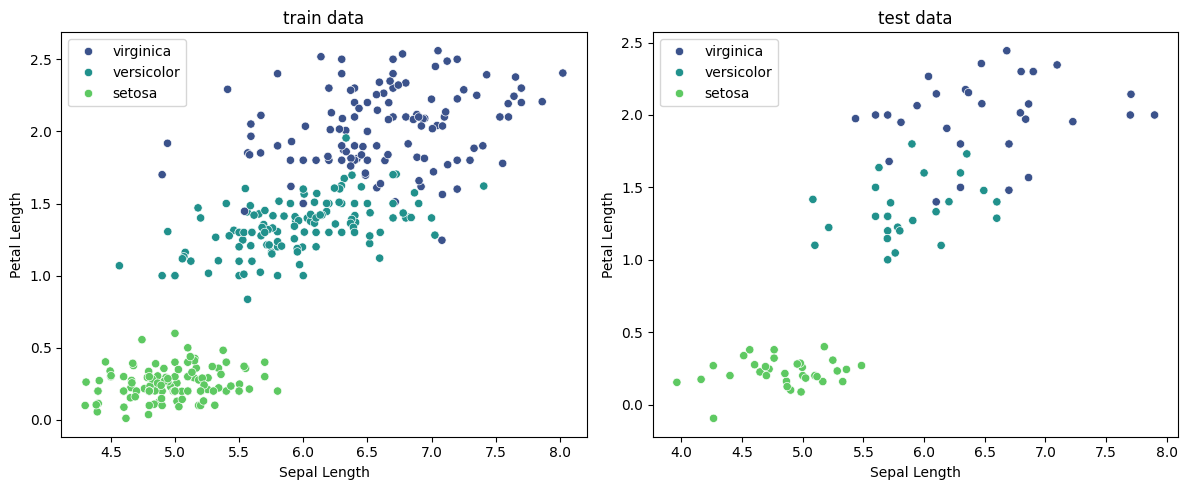

In [103]:
# 훈련 세트와 테스트 세트 시각화 함수 정의
def plot_train_test_sets(X_train, X_test, y_train, y_test):
    plt.figure(figsize=(12, 5))

    # 훈련 세트 시각화
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=X_train[:, 0], y=X_train[:, 3], hue=y_train, palette='viridis')
    plt.title('train data')
    plt.xlabel('Sepal Length')
    plt.ylabel('Petal Length')

    # 테스트 세트 시각화
    plt.subplot(1, 2, 2)
    sns.scatterplot(x=X_test[:, 0], y=X_test[:, 3], hue=y_test, palette='viridis')
    plt.title('test data')
    plt.xlabel('Sepal Length')
    plt.ylabel('Petal Length')

    plt.tight_layout()
    plt.show()

# 시각화 함수 호출
plot_train_test_sets(X_train, X_test, y_train, y_test)